# Final: saving all HMM data, of which the states timecourses.

## The libraries and methods we need:

In [1]:
import numpy as np
from loader import load_oneIC

In [2]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
import h5py

In [5]:
import xarray as xr

In [6]:
directory = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

## The routine:

---- SUBJECT2, IC1 ----
Loading the raw timecourse
Computing and loading the time-frequency wavelet transformation for 3 trials
test2
subj2, IC1: NOT POSSIBLE


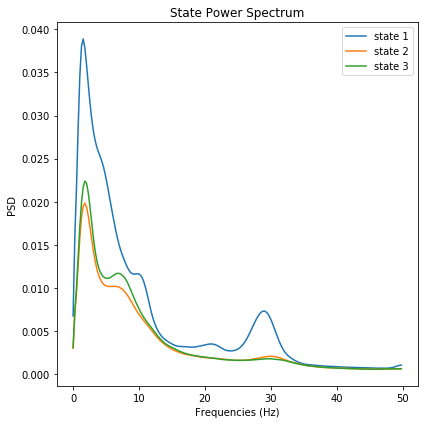

In [14]:
subj_list = [i for i in range(2,9)] + [i for i in range(10,13)] + [14] + [i for i in range(16, n_subj+1)] 
                                                                            # All except subjects 1, 9, 13, 15
# for subj in subj_list:  
#     for IC in range(1, n_IC+1): 
for subj in [2]:
    tcourses = []
    psds = []
    for IC in [1]:
        try:
            print(f"---- SUBJECT{subj}, IC{IC} ----")
            # Loading all data for subject{subj}, IC{IC}
            data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC)
            
            # Finding and saving the model
#             big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
#             x = big_timecourse.reshape(-1, 1)
            
            tcourse_disk = xr.open_dataset(f"tde-hmm2/19.06 nc_files/su{subj}IC{IC}-states_timecourse_256Hz.nc")
            tcourses.append(np.concatenate((np.zeros((29,3)), tcourse_disk["states_timecourse_256Hz"].values, np.zeros((28,3))))
            
            psddata = xr.open_dataset(f"tde-hmm2/19.06 nc_files/su{subj}IC{IC}-states_psd.nc")
            psds[IC] = psddata["states_psd"].values
            
            # Saving the Power Spectral Density of each state
            fig = plt.figure(figsize=(6, 6))
            plt.title('State Power Spectrum')
            max_power = np.zeros(n_states)
            max_freq = np.zeros(n_states)
            freqs = np.arange(0, 50, 50/196)
            for i in range(n_states):
                max_power[i] = np.amax(psd[i, 80:])
                plt.plot(freqs, psd[i])
            plt.ylabel('PSD')
            plt.xlabel('Frequencies (Hz)')
            plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
            plt.tight_layout()
            
            # Saving probability timecourses of the states over the tfr 
            time = data['time_axis']
            bigtime = np.concatenate([time+4+(7*i) for i in range(3)])
            bigtfr = np.concatenate([data[f'tfr_256Hz trial{i+1}'] for i in range(3)], axis=2)
            
            print("test2")
            
            plot_hmm_over_bigtfr(   
                bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
                subj, IC, # which IC of which subject is of interest here, how many trials
                n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
                save=False # do we really want to save the figure?
            )
            print(f"subj{subj}, IC{IC}: OK")
        except:
            print(f"subj{subj}, IC{IC}: NOT POSSIBLE")

We want to access the data in our .nc files and then use analyse them to have plots etc.

For example, we could want to :
- Plot the states timecourse over a tfr
- Plot the statewise PSD
- Plot the statewise coherence and PDC
- Plot the fractional occupancy of states (over a tfr)
- 

In [7]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_lags = lags.shape[0]
n_iter=100
n_states=3    # for the Hidden Markov Model
n_components=40     # For the principal component analysis
covariance_type='diag'
model_type='GMMHMM'
tol=0.01
n_mix=1

In [8]:
psd_disk = xr.open_dataset("tde-hmm2/19.06 nc_files/su2IC1-states_psd.nc")

In [9]:
psd = psd_disk["states_psd"].values

In [10]:
tcourse_disk = xr.open_dataset("tde-hmm2/19.06 nc_files/su2IC1-states_timecourse_256Hz.nc")

In [11]:
tcourse_disk.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:                  (states: 3, time: 1210218)
Coordinates:
    subject                  int32 ...
    IC                       int32 ...
Dimensions without coordinates: states, time
Data variables:
    states_timecourse_256Hz  (time, states) float64 ...>

In [13]:
tcourse = np.concatenate((np.zeros((29,3)), tcourse_disk["states_timecourse_256Hz"].values, np.zeros((28,3))))
tcourse.shape

(1210275, 3)

In [15]:
big_timecourse.shape

(1210275,)

In [24]:
1210275/time.shape[0]

675.0

In [26]:
n_trials

675

In [25]:
time.shape

(1793,)

In [22]:
psd.shape

(3, 196)

In [20]:
type(tcourse_disk["states_timecourse_256Hz"])

xarray.core.dataarray.DataArray

In [23]:
data

{'raw_timecourse_256Hz': array([[ 0.37716426,  0.24426569,  0.03565808, ..., -0.15173157,
         -0.42819368, -0.42819368],
        [ 0.6849094 ,  0.88440528,  0.98974246, ...,  0.22416244,
          0.0390227 ,  0.0390227 ],
        [ 1.30318949,  1.16970983,  0.72009522, ...,  0.34728856,
          0.15524884,  0.15524884],
        ...,
        [ 0.50273357,  0.29446405, -0.18365798, ..., -0.74059002,
         -0.27416589, -0.27416589],
        [-0.12374547, -0.26988214, -0.42160698, ..., -0.5756255 ,
         -0.74774575, -0.74774575],
        [ 0.1918411 ,  0.2370817 ,  0.32560655, ...,  0.0075176 ,
          0.35789317,  0.35789317]]),
 'freq_axis': array([ 2.        ,  2.57142857,  3.        ,  3.57142857,  4.        ,
         4.57142857,  5.        ,  5.57142857,  6.        ,  6.57142857,
         7.        ,  7.57142857,  8.        ,  8.57142857,  9.        ,
         9.57142857, 10.        , 10.57142857, 11.        , 11.57142857,
        12.        , 12.57142857, 13.       

In [24]:
freqs

array([ 0.        ,  0.25510204,  0.51020408,  0.76530612,  1.02040816,
        1.2755102 ,  1.53061224,  1.78571429,  2.04081633,  2.29591837,
        2.55102041,  2.80612245,  3.06122449,  3.31632653,  3.57142857,
        3.82653061,  4.08163265,  4.33673469,  4.59183673,  4.84693878,
        5.10204082,  5.35714286,  5.6122449 ,  5.86734694,  6.12244898,
        6.37755102,  6.63265306,  6.8877551 ,  7.14285714,  7.39795918,
        7.65306122,  7.90816327,  8.16326531,  8.41836735,  8.67346939,
        8.92857143,  9.18367347,  9.43877551,  9.69387755,  9.94897959,
       10.20408163, 10.45918367, 10.71428571, 10.96938776, 11.2244898 ,
       11.47959184, 11.73469388, 11.98979592, 12.24489796, 12.5       ,
       12.75510204, 13.01020408, 13.26530612, 13.52040816, 13.7755102 ,
       14.03061224, 14.28571429, 14.54081633, 14.79591837, 15.05102041,
       15.30612245, 15.56122449, 15.81632653, 16.07142857, 16.32653061,
       16.58163265, 16.83673469, 17.09183673, 17.34693878, 17.60

In [29]:
big_timecourse.shape

(1210275,)

In [28]:
# ds = xr.Dataset(
#     {
#         "tmin": (("time", "location"), tmin_values),
#         "tmax": (("time", "location"), tmax_values),
#     },
#     {"time": times, "location": ["IA", "IN", "IL"]},
# )

ds = xr.Dataset(
    {
        "states_timecourse": (("time", "states"), tcourse),
        "states_psd": (("states", "freq"), psd),
    },
    {
        "time":big_timecourse[:1210218],
        "freq":freqs,
        "states":[1,2,3],
    }
)

In [30]:
ds

<xarray.Dataset>
Dimensions:            (freq: 196, states: 3, time: 1210218)
Coordinates:
  * time               (time) float64 0.3772 0.2443 0.03566 ... -0.2329 -0.06988
  * freq               (freq) float64 0.0 0.2551 0.5102 ... 49.23 49.49 49.74
  * states             (states) int32 1 2 3
Data variables:
    states_timecourse  (time, states) float64 4.094e-164 1.703e-25 ... 0.9994
    states_psd         (states, freq) float64 0.006749 0.01575 ... 0.0006191

In [55]:
newds = xr.concat([ds,ds2,ds3,ds4], "IC")

In [60]:
newds["states_psd"]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [59]:
newds.assign_coords({"IC": [1,2,3,4]})

<xarray.Dataset>
Dimensions:            (IC: 4, freq: 196, states: 3, time: 1210218)
Coordinates:
  * time               (time) float64 0.3772 0.2443 0.03566 ... -0.2329 -0.06988
  * freq               (freq) float64 0.0 0.2551 0.5102 ... 49.23 49.49 49.74
  * states             (states) int32 1 2 3
  * IC                 (IC) int32 1 2 3 4
Data variables:
    states_timecourse  (IC, time, states) float64 4.094e-164 ... 0.9994
    states_psd         (IC, states, freq) float64 0.006749 0.01575 ... 0.0006191

In [62]:
big_timecourse.shape[0] - tcourse.shape[0]

57

In [63]:
lags = np.arange(-29, 29)
i = 0
while lags[i]<0:
    i+=1
i

29

In [65]:
tcourse[1]

array([6.07693976e-06, 5.80948647e-03, 9.94184436e-01])

In [68]:
ntcourse = np.zeros((big_timecourse.shape[0],3))
for i in range(tcourse.shape[0]):
    ntcourse[i+29] = tcourse[i]

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000

In [70]:
ntcourse[tcourse.shape[0]+28:]

array([[1.32411092e-05, 5.40573271e-04, 9.99446186e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000